### Instalação das bibliotecas 

In [2]:
%pip install pycaret
%pip install pandas 
%pip install numpy
%pip install matplotlib
%pip install seaborn


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
 
df_path = r'./Asset/sales.csv'
df = pd.read_csv(df_path)

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          143 non-null    object 
 1   Weekly_Sales  143 non-null    float64
 2   Holiday_Flag  143 non-null    int64  
 3   Temperature   143 non-null    float64
 4   Fuel_Price    143 non-null    float64
 5   CPI           143 non-null    float64
 6   Unemployment  143 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 7.9+ KB


Descrição da base de dados:

- Date: indica a data em que a observação foi feita;

- Weekly_Sales: as vendas da empresa na semana, indicada pelo campo Date;

- Holiday_Flag: indica se houve um feriado na semana medida;

- Temperature: a temperatura média registrada naquela semana;

- Fuel_Price: preço do combustível. Deve ser dividido por 1.000 para se obter o preço em reais e centavos;

- CPI: índice que indica o nível de atividade econômica da região;

- Unemployment: nível de desemprego medido nacionalmente. Deve ser dividido por 1.000 para se obter a informação em percentual.

In [28]:
df.head()

,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,05-02-2010,1643690.90,0,42.31,2572.0,211.096358,8106
1,12-02-2010,1641957.44,1,38.51,2548.0,211.242170,8106
2,19-02-2010,1611968.17,0,39.93,2514.0,211.289143,8106
3,26-02-2010,1409727.59,0,46.63,2561.0,211.319643,8106
4,05-03-2010,1554806.68,0,46.50,2625.0,211.350143,8106


### Training and Processing: Machine Learning

Processamento dos dados

In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from datetime import datetime

def process_data():
    df = pd.read_csv("./Asset/sales.csv")
   
    # 1. Tratamento de tipos de dados
    # Converter a coluna de data para o formato datetime
    df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")

    # 2. Ajustar as colunas conforme descrição
    df["Fuel_Price"] = (
        df["Fuel_Price"] / 1000
    )  # Dividir por 1000 para obter o preço em reais
    df["Unemployment"] = (
        df["Unemployment"] / 1000
    )  # Dividir por 1000 para obter o percentual

    # 3. Engenharia de features
    # Extrair componentes de data
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Week"] = df["Date"].dt.isocalendar().week
    df["Day_of_week"] = df["Date"].dt.dayofweek

    # Criar variáveis sazonais usando transformações cíclicas para mês e semana
    df["Month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
    df["Month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)
    df["Week_sin"] = np.sin(2 * np.pi * df["Week"] / 52)
    df["Week_cos"] = np.cos(2 * np.pi * df["Week"] / 52)

    # 4. Criar lag features (vendas das semanas anteriores)
    df["Sales_Lag_1"] = df["Weekly_Sales"].shift(1)
    df["Sales_Lag_2"] = df["Weekly_Sales"].shift(2)
    df["Sales_Lag_4"] = df["Weekly_Sales"].shift(4)

    # 5. Criar features de média móvel
    df["Sales_Rolling_Mean_4"] = df["Weekly_Sales"].rolling(window=4).mean()
    # df["Sales_Rolling_Mean_8"] = df["Weekly_Sales"].rolling(window=8).mean()

    # 6. Remover linhas com valores NaN (criados pelos lags e médias móveis)
    df_clean = df.dropna().reset_index(drop=True)

    # 7. Separar features e target
    X = df_clean.drop(["Weekly_Sales", "Date"], axis=1)
    y = df_clean["Weekly_Sales"]

    # 8. Dividir em conjuntos de treino e teste (80% treino, 20% teste)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 9. Normalizar/padronizar as features numéricas
    # Identificar colunas numéricas (excluindo as categóricas como Holiday_Flag)
    numeric_features = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
    numeric_features.remove("Holiday_Flag")  # Remover a coluna binária

    # Aplicar StandardScaler
    scaler = StandardScaler()
    X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
    X_test[numeric_features] = scaler.transform(X_test[numeric_features])

    # 10. Salvar os dados preparados
    # Salvar os conjuntos de treino e teste
    return {
        'df': df_clean,
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
    }


In [49]:
df, X_train, X_test, y_train, y_test = process_data().values()

scaler = StandardScaler()
numeric_features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
df[numeric_features] = scaler.fit_transform(df[numeric_features])
df.head()


,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Day_of_week,Month_sin,Month_cos,Week_sin,Week_cos,Sales_Lag_1,Sales_Lag_2,Sales_Lag_4,Sales_Rolling_Mean_4
0,2010-03-05,0.001040,-0.263117,-1.652760,-0.244880,-1.107184,1.347437,2010,3,9,4,1.430529,0.154288,1.220391,0.832670,-0.918370,0.363824,0.563614,-0.000736
1,2010-03-12,-0.734328,-0.263117,-0.825950,-0.205922,-1.100125,1.347437,2010,3,10,4,1.430529,0.154288,1.288698,0.670867,0.004880,-0.922970,0.552587,-0.508217
2,2010-03-19,-0.523959,-0.263117,-1.061031,-2.677264,-1.138316,1.347437,2010,3,11,4,1.430529,0.154288,1.338213,0.501467,-0.728640,0.000123,0.361822,-0.857841
3,2010-03-26,-0.958334,-0.263117,-1.290253,-0.145629,-1.184048,1.347437,2010,3,12,4,1.430529,0.154288,1.368214,0.326938,-0.518800,-0.733273,-0.924654,-0.871123
4,2010-04-02,0.257263,-0.263117,-0.497863,-0.157687,-1.229781,0.559867,2010,4,13,4,1.244838,-0.577146,1.378263,0.149828,-0.952083,-0.523468,-0.001789,-0.770433


Trainamento do machine learning

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time


# Função para avaliar modelos
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Registrar tempo de início
    start_time = time.time()

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Tempo de treinamento
    train_time = time.time() - start_time

    # Fazer previsões
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calcular métricas
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    # Retornar resultados
    return {
        "model_name": model_name,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
        "train_mae": train_mae,
        "test_mae": test_mae,
        "train_r2": train_r2,
        "test_r2": test_r2,
        "train_time": train_time,
        "model": model,
    }

def train_ml():
    # Processar dados
    data = process_data()
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']


    # Definir modelos para teste
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=1.0),
        "Lasso Regression": Lasso(alpha=0.1),
        "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
        "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
        "Random Forest": RandomForestRegressor(
            n_estimators=100, max_depth=15, random_state=42
        ),
        "Gradient Boosting": GradientBoostingRegressor(
            n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42
        ),
        "SVR": SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1),
        "KNN": KNeighborsRegressor(n_neighbors=5),
    }

    # Avaliar cada modelo e armazenar resultados
    results = []
    for model_name, model in models.items():
        print(f"Treinando modelo: {model_name}")
        result = evaluate_model(model, X_train, X_test, y_train, y_test, model_name)
        results.append(result)

        # Salvar o modelo treinado
        with open(f'models/{model_name.replace(" ", "_").lower()}.pkl', "wb") as f:
            pickle.dump(model, f)

        # print(f"Modelo {model_name} treinado e avaliado.")
        # print(f"RMSE (Teste): {result['test_rmse']:.2f}")
        # print(f"R² (Teste): {result['test_r2']:.4f}")
        # print("-" * 50)

    # Criar DataFrame com resultados
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values("test_rmse")
    results_df.to_csv("model_comparison_results.csv", index=False)

    # Visualizar comparação de modelos
    plt.figure(figsize=(12, 8))
    sns.barplot(x="model_name", y="test_rmse", data=results_df)
    plt.title("Comparação de Modelos - RMSE (Teste)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    # plt.show()

    plt.figure(figsize=(12, 8))
    sns.barplot(x="model_name", y="test_r2", data=results_df)
    plt.title("Comparação de Modelos - R² (Teste)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    # plt.show()


    # Identificar o melhor modelo com base no RMSE de teste
    best_model_idx = results_df["test_rmse"].idxmin()
    best_model_name = results_df.loc[best_model_idx, "model_name"]
    best_model = models[best_model_name]

    # print(f"\nMelhor modelo: {best_model_name}")
    # print(f"RMSE (Teste): {results_df.loc[best_model_idx, 'test_rmse']:.2f}")
    # print(f"R² (Teste): {results_df.loc[best_model_idx, 'test_r2']:.4f}")

    # Se o melhor modelo for árvore ou ensemble, analisar importância das features
    if best_model_name in ["Decision Tree", "Random Forest", "Gradient Boosting"]:
        # Obter importância das features
        if hasattr(best_model, "feature_importances_"):
            feature_importance = pd.DataFrame(
                {"Feature": X_train.columns, "Importance": best_model.feature_importances_}
            ).sort_values("Importance", ascending=False)

            # Salvar importância das features
            feature_importance.to_csv("feature_importance.csv", index=False)

            # Visualizar importância das features
            plt.figure(figsize=(12, 8))
            sns.barplot(x="Importance", y="Feature", data=feature_importance.head(15))
            plt.title(f"Importância das Features - {best_model_name}")
            plt.tight_layout()
            # plt.show()
    print(
        "Comparação de modelos concluída. Resultados salvos em 'model_comparison_results.csv'."
    )

    return best_model


In [24]:
data = process_data()
df = data['df']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizar correlação entre variáveis numéricas, após o processamento
df_numeric = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(10, 8))
sns.heatmap(df_numeric.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)

Validando modelo

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import time


def validate_model():
    data = process_data()
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']

    best_model = train_ml()

    # 1. Realizar validação cruzada para avaliar a robustez do modelo
    print("Realizando validação cruzada...")
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    cv_rmse = -cv_scores
    print(f"RMSE médio na validação cruzada: {cv_rmse.mean():.2f} (desvio padrão: {cv_rmse.std():.2f})")

    # 2. Analisar importância das features
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    # Salvar importância das features
    print('Importancia das features: \n',feature_importance)

    # Visualizar importância das features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
    plt.title('Top 10 Features Mais Importantes - Gradient Boosting')
    plt.tight_layout()
    plt.show()

    # 3. Fazer previsões no conjunto de teste
    y_pred = best_model.predict(X_test)

    # 4. Visualizar previsões vs valores reais
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.values, label='Valores Reais')
    plt.plot(y_pred, label='Previsões')
    plt.title('Valores Reais vs Previsões - Gradient Boosting')
    plt.xlabel('Índice da Amostra')
    plt.ylabel('Weekly_Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 5. Visualizar dispersão entre valores reais e previstos
    plt.figure(figsize=(10, 8))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title('Dispersão: Valores Reais vs Previsões')
    plt.xlabel('Valores Reais')
    plt.ylabel('Previsões')
    plt.tight_layout()
    plt.show()

    # 6. Calcular erro residual
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Resíduos vs Valores Previstos')
    plt.xlabel('Previsões')
    plt.ylabel('Resíduos')
    plt.tight_layout()
    plt.show()
    
    # 7. Histograma dos resíduos
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Distribuição dos Resíduos')
    plt.xlabel('Resíduo')
    plt.tight_layout()
    plt.show()

    # 8. Salvar métricas finais de validação
    final_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred),
        'CV_RMSE_Mean': cv_rmse.mean(),
        'CV_RMSE_Std': cv_rmse.std()
    }

    with open('final_validation_metrics.txt', 'w') as f:
        f.write("Métricas Finais de Validação do Modelo Gradient Boosting:\n\n")
        f.write(f"RMSE no conjunto de teste: {final_metrics['RMSE']:.2f}\n")
        f.write(f"R² no conjunto de teste: {final_metrics['R2']:.4f}\n")
        f.write(f"RMSE médio na validação cruzada: {final_metrics['CV_RMSE_Mean']:.2f}\n")
        f.write(f"Desvio padrão do RMSE na validação cruzada: {final_metrics['CV_RMSE_Std']:.2f}\n")

    print("Validação final do modelo concluída. Visualizações e métricas salvas.")


In [ ]:
validate_model()

### PyCaret: Analise de modelos de ml

préprocessamento

In [52]:
def escala_util(df):
    # transforma as colunas o Fuel_Price em real e Unemployment em porcentagem
    df_escala = df.copy()
    df_escala['Fuel_Price'] = df_escala['Fuel_Price'] / 1000
    df_escala['Unemployment'] = df_escala['Unemployment'] / 1000
    return df_escala

def new_features(df):
    # cria a nova feature
    df_new_feature = df.copy()

    # features sazonais
    df_new_feature['Week'] = pd.to_datetime(df_new_feature['Date'], format='%d-%m-%Y').dt.isocalendar().week
    df_new_feature['Month'] = pd.to_datetime(df_new_feature['Date'], format='%d-%m-%Y').dt.month
    df_new_feature['Quarter'] = pd.to_datetime(df_new_feature['Date'], format='%d-%m-%Y').dt.quarter

    # criar colunas de lag para Weekly_Sales
    df_new_feature['Weekly_Sales_Lag1'] = df_new_feature['Weekly_Sales'].shift(1)
    df_new_feature['Weekly_Sales_Lag2'] = df_new_feature['Weekly_Sales'].shift(2)
    df_new_feature['Weekly_Sales_Lag4'] = df_new_feature['Weekly_Sales'].shift(4)

    # criar colunas de media móvel para Weekly_Sales
    df_new_feature['Weekly_Sales_MA4'] = df_new_feature['Weekly_Sales'].rolling(window=4).mean()
    df_new_feature['Weekly_Sales_MA12'] = df_new_feature['Weekly_Sales'].rolling(window=4).mean()
    
    df_new_feature['New_Feature'] = df_new_feature['Fuel_Price'] * df_new_feature['Unemployment']
    return df_new_feature

#### PyCaret: Regression Model

In [54]:
from pycaret.regression import *
# The error occurs because 'Weekly_Sales' is a continuous variable, not suitable for classification.
# You should use pycaret.regression for regression tasks.
import pandas as pd
 
df_path = r'./Asset/sales.csv'
df = pd.read_csv(df_path)

df = escala_util(df)
df = new_features(df)

df.dropna(inplace=True)
s = setup(data=df, target='Weekly_Sales')

,Description,Value
0,Session id,5749
1,Target,Weekly_Sales
2,Target type,Regression
3,Original data shape,"(139, 16)"
4,Transformed data shape,"(139, 16)"
5,Transformed train set shape,"(97, 16)"
6,Transformed test set shape,"(42, 16)"
7,Numeric features,14
8,Categorical features,1
9,Preprocess,True


In [59]:
X_train = s.get_config('X_train')
X_test = s.get_config('X_test')
y_train = s.get_config('y_train')
y_test = s.get_config('y_test')

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((97, 15), (42, 15), (97,), (42,))

In [55]:
best = s.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,71094.7412,11093972856.1529,96536.8491,0.3702,0.0583,0.0443,0.0280
ada,AdaBoost Regressor,105359.8271,27000985043.4314,145721.6057,-0.1867,0.0878,0.0647,0.0360
llar,Lasso Least Angle Regression,105237.4574,26160208352.8530,143723.7229,-0.1894,0.0865,0.0648,0.0150
dt,Decision Tree Regressor,106061.3656,27027388553.3225,145807.2322,-0.2015,0.0879,0.0652,0.0150
rf,Random Forest Regressor,105904.8611,25847560028.3644,143810.9682,-0.2093,0.0868,0.0655,0.0690
gbr,Gradient Boosting Regressor,107690.8089,27286433878.9791,146968.9836,-0.2300,0.0888,0.0664,0.0360
knn,K Neighbors Regressor,84719.2648,17459924608.0000,119531.0109,-0.2307,0.0703,0.0516,0.0200
lr,Linear Regression,107845.9364,27393056737.4483,147295.2097,-0.2364,0.0890,0.0665,2.2230
lasso,Lasso Regression,107845.9364,27393056731.0835,147295.2096,-0.2364,0.0890,0.0665,0.0140
en,Elastic Net,107845.9363,27393056696.0291,147295.2095,-0.2364,0.0890,0.0665,0.0130


In [65]:
from pycaret.regression import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def validate_pycaret_model(pycaret_setup, model):
    """
    Properly validate a PyCaret model using its internal data splits
    to maintain consistency with PyCaret's reported metrics.
    
    Parameters:
    - pycaret_setup: The PyCaret setup object (your 's' variable)
    - model: The trained PyCaret model
    """
    # Get the data splits PyCaret actually used
    X_train = pycaret_setup.X_train
    X_test = pycaret_setup.X_test
    y_train = pycaret_setup.y_train
    y_test = pycaret_setup.y_test
    
    # Get predictions (this uses PyCaret's pipeline)
    y_pred = predict_model(model, data=X_test)['prediction_label']
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print("\nTest Set Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")
    
    # Plotting functions (same as before but using PyCaret's data)
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.values, label='Actual Values')
    plt.plot(y_pred.values, label='Predictions', alpha=0.7)
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Weekly_Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.tight_layout()
    plt.show()
    
    # Residual analysis
    residuals = y_test - y_pred
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residuals vs Predicted Values')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residual Distribution')
    plt.xlabel('Residual')
    plt.tight_layout()
    plt.show()

    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }


Test Set Metrics:
RMSE: 130988.17
MAE: 84353.55
R²: 0.0503


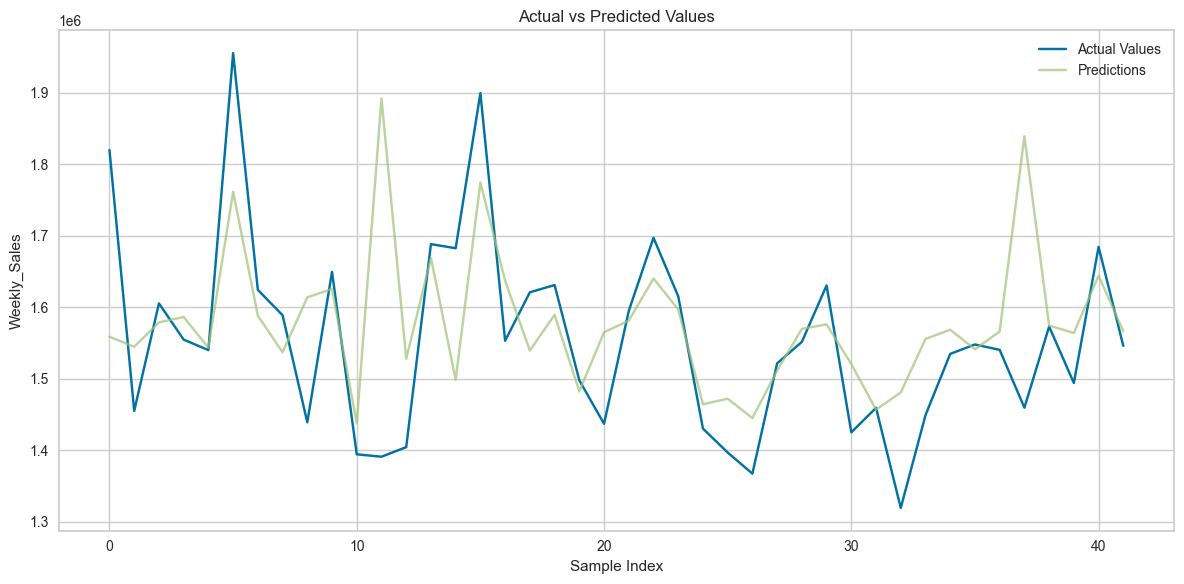

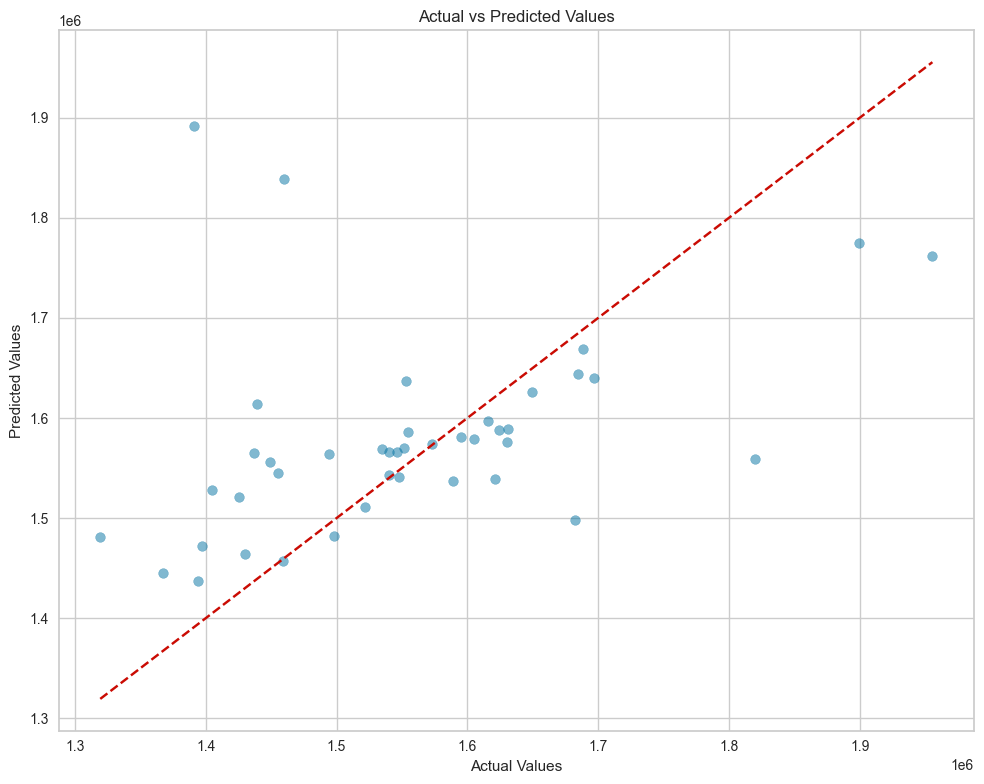

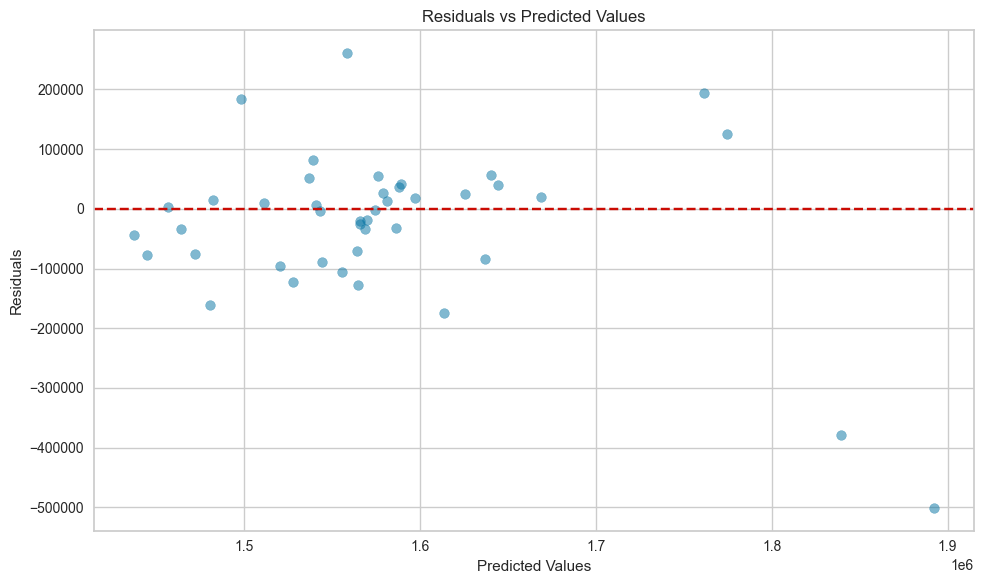

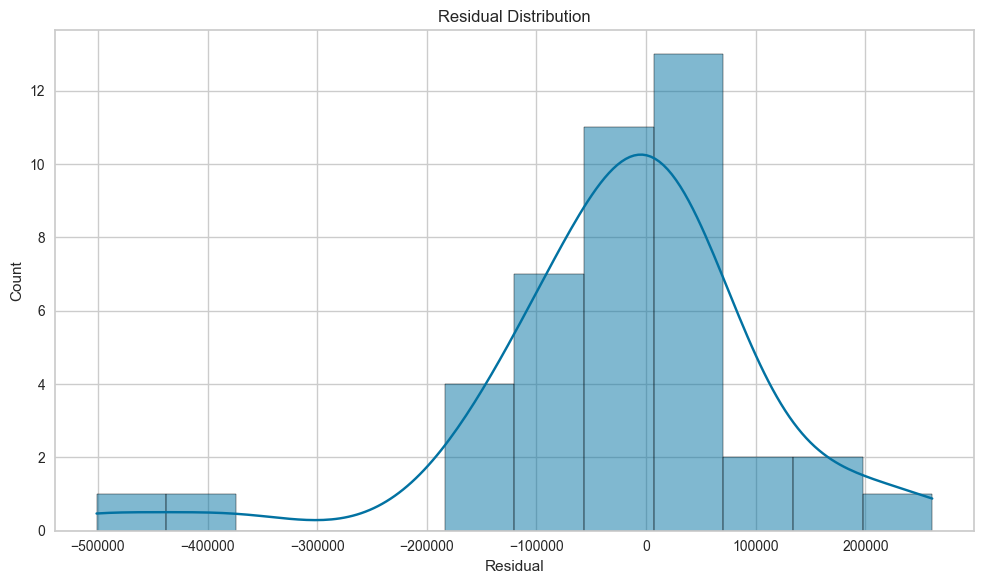

{'RMSE': 130988.17352895491,
 'MAE': 84353.55281992668,
 'R2': 0.05027337022326106}

In [67]:

best_model = best

validate_pycaret_model(s, best_model)

In [ ]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

#### PyCaret: TimeSeriesModel

In [96]:
def create_time_features(df):
    df_time_features = df.copy()
    # features sazonais
    df_time_features['Week'] = pd.to_datetime(df_time_features['Date'], format='%d-%m-%Y').dt.isocalendar().week
    df_time_features['Month'] = pd.to_datetime(df_time_features['Date'], format='%d-%m-%Y').dt.month
    df_time_features['Quarter'] = pd.to_datetime(df_time_features['Date'], format='%d-%m-%Y').dt.quarter

    
    # Remove lag features - these cause data leakage in time series!
    # They should be created within PyCaret's pipeline instead
    
    return df_time_features

In [123]:
import pandas as pd

path = r'./Asset/sales.csv'
df = pd.read_csv(path)

df = escala_util(df)
df = create_time_features(df)
df.dropna(inplace=True)

df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')  # Ensure Date is datetime
df = df.set_index('Date')  # Set Date as index

df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2010-02-05 to 2012-10-26
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Weekly_Sales  143 non-null    float64
 1   Holiday_Flag  143 non-null    int64  
 2   Temperature   143 non-null    float64
 3   Fuel_Price    143 non-null    float64
 4   CPI           143 non-null    float64
 5   Unemployment  143 non-null    float64
 6   Week          143 non-null    UInt32 
 7   Month         143 non-null    int32  
 8   Quarter       143 non-null    int32  
dtypes: UInt32(1), float64(5), int32(2), int64(1)
memory usage: 9.6 KB


In [133]:
from pycaret.time_series import *

s = setup(
    data=df,
    target='Weekly_Sales',
    fh=12,  # Forecast horizon - set to meaningful business period (e.g., 12 weeks)
    fold_strategy="sliding",  # Better for time series than "expanding"
    fold=3,  # Fewer folds for more training data
    session_id=123
)

,Description,Value
0,session_id,123
1,Target,Weekly_Sales
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(143, 9)"
5,Transformed data shape,"(143, 9)"
6,Transformed train set shape,"(131, 9)"
7,Transformed test set shape,"(12, 9)"
8,Rows with missing values,0.0%
9,Fold Generator,SlidingWindowSplitter


In [134]:
best = compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,1.2862,1.4017,76104.3877,106712.9616,0.0448,0.0456,0.4311,0.4500
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,1.4296,1.3738,85132.4906,105115.2150,0.0512,0.0517,0.3767,0.4200
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.4502,1.5270,85848.0202,116225.2468,0.0503,0.0516,0.3315,0.3400
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,1.4591,1.4129,88287.4467,109883.9527,0.0549,0.0552,0.1175,0.2900
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,1.4769,1.5640,86741.2217,118376.7568,0.0506,0.0517,0.3756,0.5267
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,1.4892,1.3976,89305.1645,108044.4185,0.0554,0.0557,0.1444,0.5000
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,1.6934,1.5684,101864.5779,121971.4353,0.0641,0.0632,-0.1560,0.3200
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,1.8598,2.0473,109354.5463,154185.3925,0.0632,0.0652,-0.0041,0.2933
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,2.0139,2.0536,118976.3547,155426.0485,0.0706,0.0717,-0.1270,0.3967
croston,Croston,2.0319,2.0686,120736.3551,157525.9926,0.0716,0.0729,-0.1147,0.0167


In [135]:
def validate_time_series_model(pycaret_setup, model):
    # Get the final predictions
    final_predictions = predict_model(model)
    
    # Plot results
    plot_model(model, plot='forecast', data_kwargs={'fh':24})  # Extended forecast
    
    # Residual analysis
    plot_model(model, plot='residuals')
    
    # Diagnostics
    plot_model(model, plot='diagnostics')
    
    
    
    return final_predictions

# Validate your best model
results = validate_time_series_model(s, best)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ExtraTreesRegressor,0.4267,0.3913,30045.2251,35092.1114,0.0194,0.0192,0.7381


In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.
In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.
In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.
In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.


In [136]:
predictions = predict_model(best, fh=20)  # Previsão para 12 períodos à frente
predictions

,y_pred
2012-08-04/2012-08-10,1.602581e+06
2012-08-11/2012-08-17,1.603324e+06
2012-08-18/2012-08-24,1.534150e+06
2012-08-25/2012-08-31,1.635424e+06
2012-09-01/2012-09-07,1.655281e+06
2012-09-08/2012-09-14,1.568907e+06
2012-09-15/2012-09-21,1.477266e+06
2012-09-22/2012-09-28,1.464502e+06
2012-09-29/2012-10-05,1.727664e+06
2012-10-06/2012-10-12,1.552387e+06


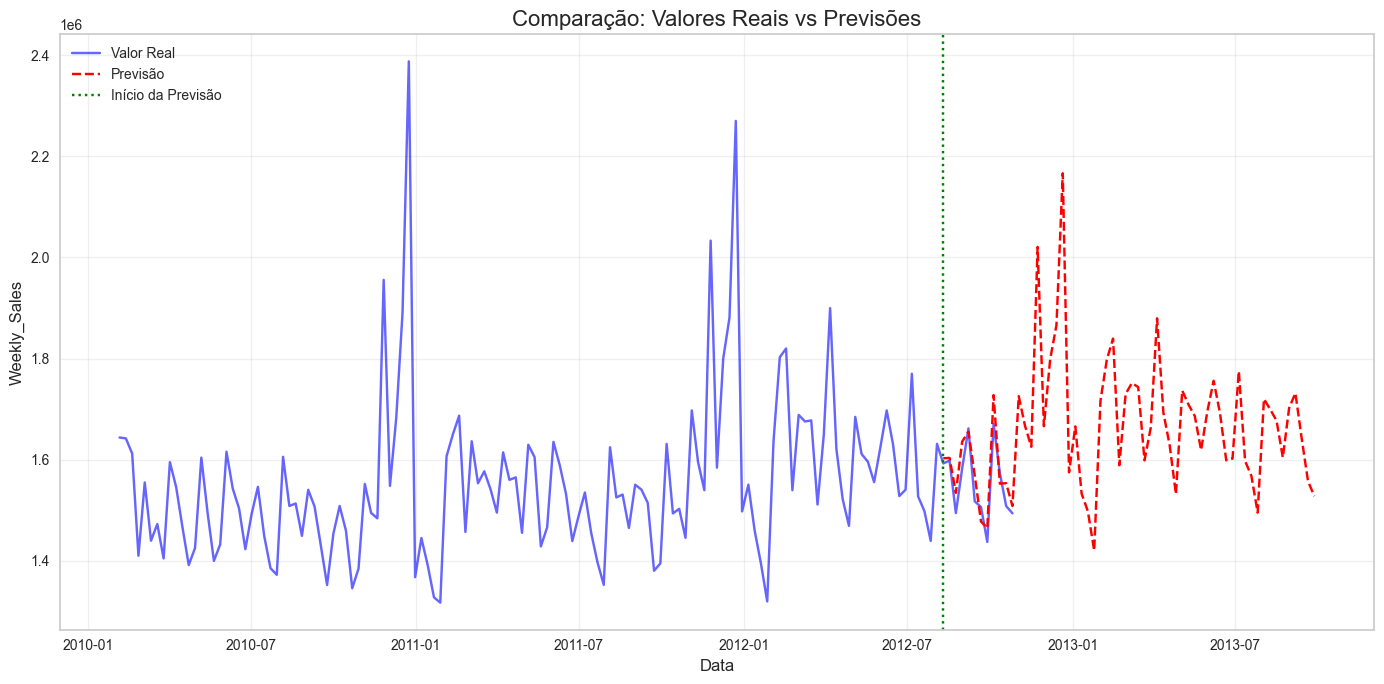

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obter as previsões
predictions = predict_model(best, fh=60)  # Previsão para 12 períodos à frente

# Criar o gráfico
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Weekly_Sales'], label='Valor Real', color='blue', alpha=0.6)
plt.plot(predictions.index, predictions['y_pred'], 
         label='Previsão', color='red', linestyle='--')

# Destacar a área de previsão
forecast_start = predictions.index[0]
plt.axvline(x=forecast_start, color='green', linestyle=':', 
            label='Início da Previsão')

# plt.fill_between(predictions.index, 
#                  predictions['prediction_lower'], 
#                  predictions['prediction_upper'],
#                  color='red', alpha=0.1, label='Intervalo de Confiança')

plt.title('Comparação: Valores Reais vs Previsões', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Weekly_Sales', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [107]:
plot_model(best, plot='ts')

### Long Term Memory: Not Done

In [23]:
%pip install tensorflow

  Using cached tensorflow-2.19.0-cp311-cp311-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.4-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached wrapt-1.17.2-cp311-cp311-win_amd64.whl.metadata (6.5 kB)
  Using cached grpcio-1.71.0-cp311-cp311-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.9.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached h5py-3.13.0-cp311-cp311-win_amd64.whl.metadata (2.5 kB)
  Using cac

In [ ]:
# Imports
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import layers, models